In [1]:
import uproot
import numpy as np
import awkward
import concurrent.futures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
executor = concurrent.futures.ThreadPoolExecutor(8)
filename = '4gev_1e_tskim_v12_kaons_ldmx-det-v12_toughkskim.root'

# radius of containment for each ECal layer
radius_beam_68 = [4.73798004, 4.80501156, 4.77108164, 4.53839401, 4.73273021,
4.76662872, 5.76994967, 5.92028271, 7.28770932, 7.60723209,
9.36050277, 10.03247442, 12.14656399, 13.16076587, 15.88429816,
17.03559932, 20.32607264, 21.75096888, 24.98745754, 27.02031225,
30.78043038, 33.03033267, 37.55088662, 40.14062264, 47.95964745,
55.96441035, 66.33128366, 70.42649416, 86.68563278, 102.49022815,
119.06854141, 121.20048803, 127.5236134, 121.99024095]

# distance between each ECal layer
layer_dz = np.array([7.850, 13.300, 26.400, 33.500, 47.950, 56.550, 72.250, 81.350, 97.050, 106.150,
            121.850, 130.950, 146.650, 155.750, 171.450, 180.550, 196.250, 205.350, 221.050,
            230.150, 245.850, 254.950, 270.650, 279.750, 298.950, 311.550, 330.750, 343.350,
            362.550, 375.150, 394.350, 406.950, 426.150, 438.750])

# z-position of each ECal layer
layer_z = 240.5 + layer_dz

# list of branches we want to store from the root file
branches = []
branch_suffix = 'v3_v12'

# branchnames
ecal_branch = 'EcalRecHits_{}/EcalRecHits_{}'.format(branch_suffix, branch_suffix)
ecalSP_branch = 'EcalScoringPlaneHits_{}/EcalScoringPlaneHits_{}'.format(branch_suffix, branch_suffix)
tSP_branch = 'TargetScoringPlaneHits_{}/TargetScoringPlaneHits_{}'.format(branch_suffix, branch_suffix)
ecalVeto_branch = 'EcalVeto_{}'.format(branch_suffix)
ecalSim_branch = 'EcalSimHits_{}/EcalSimHits_{}'.format(branch_suffix, branch_suffix)

In [3]:
# add EcalRecHits branches
for leaf in ['xpos_', 'ypos_', 'zpos_', 'energy_']:
    branches.append('{}.{}'.format(ecal_branch, leaf))

# add EcalVeto branches
for leaf in ['showerRMS_', 'epAng_', 'passesVeto_']:
    branches.append('{}/{}'.format(ecalVeto_branch, leaf))

# add EcalSPHits and TargetSPHits branches
# Use EcalSPHits for fiducial/non-fiducial and TargetSPHits for trajectories
for leaf in ['x_', 'y_', 'z_', 'px_', 'py_', 'pz_', 'pdgID_', 'trackID_']:
    branches.append('{}.{}'.format(ecalSP_branch, leaf))
    branches.append('{}.{}'.format(tSP_branch, leaf))

# add EcalSimHits branches
for leaf in ['x_', 'y_', 'z_', 'pdgCodeContribs_', 'edepContribs_', 'incidentIDContribs_']:
    branches.append('{}.{}'.format(ecalSim_branch, leaf))

# add the eventNumber leaf
branches.append('EventHeader/eventNumber_')
#print (branches)

In [4]:
# use uproot and load all of the data into a dictionary: {'leaf1': [data], 'leaf2': [data], ...}
t = uproot.open(filename)['LDMX_Events']
table = t.arrays(expressions=branches, interpretation_executor=executor)

# we store all of our data into the dictionary "tree"
tree = {}
for branch in branches:
    tree[branch] = table[branch]

#print(tree.keys())


In [5]:
# find the number of events that pass through the vetoes
# record the event numbers of the events that pass through the vetoes
events = 0
eventNumbers = []
for event in range(len(tree['EventHeader/eventNumber_'])):
    events +=1
    eventNumbers.append(tree['EventHeader/eventNumber_'][event])

#print(events)
#print(eventNumbers)


In [6]:
# calculate the electron and photon trajectories

# we will store the data for the trajectory positions inside this dictionary:
trajectories = {}
b1 = []
b2 = []
b3 = []
b4 = []

# loop through all of the events
for i in range(len(tree['EventHeader/eventNumber_'])):
    tSPHits = {}
    ecalSPHits = {}
    for x in ['x_', 'y_', 'z_', 'px_', 'py_', 'pz_', 'pdgID_', 'trackID_']:
        tSPHits[x] = (table['{}.{}'.format(tSP_branch, x)])[i]
        ecalSPHits[x] = (table['{}.{}'.format(ecalSP_branch, x)])[i]
   
    # find the max pz at the target scoring plane for the recoil electron
    max_pz = 0
    r = 0
    for j in range(len(tSPHits['z_'])):
        if tSPHits['pdgID_'][j] == 11 and tSPHits['z_'][j] > 4.4 and tSPHits['z_'][j] < 4.6 and tSPHits['pz_'][j] > max_pz and tSPHits['trackID_'][j] == 1:
            max_pz = tSPHits['pz_'][j]
            r = j
    #print("Found recoil e- pz at target for event {}: {}".format(tree['EventHeader/eventNumber_'][i],max_pz))

    # find the max pz at the ecal face for the recoil electron
    max_pz_e = 0
    r_e = 0
    for j in range(len(ecalSPHits['z_'])):
        if ecalSPHits['pdgID_'][j] == 11 and ecalSPHits['z_'][j] > 239 and ecalSPHits['z_'][j] < 242 and ecalSPHits['pz_'][j] > max_pz_e and ecalSPHits['trackID_'][j] == 1:
            max_pz_e = ecalSPHits['pz_'][j]
            r_e = j
    fiducial = max_pz_e != 0
    
    if fiducial:
        E_beam = 4000
        target_dist = 241.5
        # positions and trajectory vectors of recoil e- at Ecal SP
        etraj_sp = np.array((ecalSPHits['x_'][r_e], ecalSPHits['y_'][r_e], ecalSPHits['z_'][r_e]))
        enorm_sp = np.array((ecalSPHits['px_'][r_e]/ecalSPHits['pz_'][r_e], ecalSPHits['py_'][r_e]/ecalSPHits['pz_'][r_e], 1.0))
        # positions and trajectory vectors of photon at Target SP
        pnorm_sp = np.array((-tSPHits['px_'][r]/(E_beam - tSPHits['pz_'][r]), -tSPHits['py_'][r]/(E_beam - tSPHits['pz_'][r]), 1.0))
        ptraj_sp = np.array((tSPHits['x_'][r] + target_dist*pnorm_sp[0], tSPHits['y_'][r] + target_dist*pnorm_sp[1], tSPHits['z_'][r] + target_dist))
        # store the trajectory information 
        b1.append(etraj_sp)
        b2.append(enorm_sp)
        b3.append(pnorm_sp)
        b4.append(ptraj_sp)
    else:
        etraj_sp, enorm_sp, ptraj_sp, pnorm_sp = None, None, None, None

# store the e- trajectory and its normal vector, store the photon trajectory and its normal vector
trajectories['etraj_sp'] = b1
trajectories['enorm_sp'] = b2
trajectories['pnorm_sp'] = b3
trajectories['ptraj_sp'] = b4


In [7]:
# get the PDG IDs of the hits
Pdg_ID = []
for event in range(len(tree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'])):
    # data from EcalSimHits
    sim_dict = {}
    for x in ['x_', 'y_', 'z_', 'pdgCodeContribs_', 'edepContribs_', 'incidentIDContribs_']:
        sim_dict[x] = table['{}.{}'.format(ecalSim_branch, x)][event]

    # data from EcalRecHits
    ecal_dict = {}
    for x in ['xpos_', 'ypos_', 'zpos_']:
        ecal_dict[x] = table['{}.{}'.format(ecal_branch, x)][event]

    rec_matched_ids = []
    rec_parent_ids = []

    for j in range(len(ecal_dict['zpos_'])):
        # For each hit:  Find a contrib w/ the same position, then match:
        simIndex = None # EcalSimHit index
        contribIndex = None # index of contribution within EcalSimHit
        for k in range(len(sim_dict['x_'])):
            if round(sim_dict['x_'][k]) == round(ecal_dict['xpos_'][j]) and \
                round(sim_dict['y_'][k]) == round(ecal_dict['ypos_'][j]) and \
                round(sim_dict['z_'][k]) == round(ecal_dict['zpos_'][j]):
                simIndex = k # we found a matching hit. 
                # now, go through the contribs and find the pdgID of the contrib w/ max edep:
                eDepMax = 0
                for l in range(len(sim_dict['edepContribs_'][k])):
                    if sim_dict['edepContribs_'][k][l] > eDepMax:
                        eDepMax = sim_dict['edepContribs_'][k][l]
                        contribIndex = l
        if not simIndex:  # If no EcalSimHit found, presumably noise; record
            rec_matched_ids.append(None)
            rec_parent_ids.append(None)
        else:
            rec_matched_ids.append(sim_dict['pdgCodeContribs_'][simIndex][contribIndex])
            rec_parent_ids.append(sim_dict['incidentIDContribs_'][simIndex][contribIndex])
    Pdg_ID.append(rec_matched_ids)

tree['Pdg_ID'] = Pdg_ID

In [8]:
# loop through each event and cut all of the hits within electron containment radii

# this is a new dictionary that will story only the hits that are outside the e- containment radii
cutTree = {}

eventsX = []
eventsY = []
eventsZ = []
pdgIDs = []

# loop through each event 
for event in range(len(tree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'])):
    ecal_front = 240.5
    etraj_front = np.array(trajectories['etraj_sp']) 
    ptraj_front = np.array(trajectories['ptraj_sp']) 

    # obtain the event's e- trajectory layer intercepts
    eLayerIntercepts = []
    intercept = (trajectories['etraj_sp'][event][0] + layer_dz*trajectories['enorm_sp'][event][0], 
                trajectories['etraj_sp'][event][1] + layer_dz*trajectories['enorm_sp'][event][1], 
                trajectories['etraj_sp'][event][2] + layer_dz*trajectories['enorm_sp'][event][2])
    eLayerIntercepts.append(intercept)
    eLayerIntercepts = np.concatenate(np.array(eLayerIntercepts))

    # obtain the event's photon trajectory layer intercepts
    pLayerIntercepts = []
    intercept = (trajectories['ptraj_sp'][event][0] + layer_dz*trajectories['pnorm_sp'][event][0], 
                trajectories['ptraj_sp'][event][1] + layer_dz*trajectories['pnorm_sp'][event][1], 
                trajectories['ptraj_sp'][event][2] + layer_dz*trajectories['pnorm_sp'][event][2])
    pLayerIntercepts.append(intercept)
    pLayerIntercepts = np.concatenate(np.array(pLayerIntercepts))
    
    hitsX = []
    hitsY = []
    hitsZ = []
    pdgids = []

    # loop through each hit within the event
    for hit in range(len(tree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event])):
        x = tree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event][hit]
        y = tree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.ypos_'][event][hit]
        z = tree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.zpos_'][event][hit]
        pdgid = tree['Pdg_ID'][event][hit]
        
        # loop through each layer of the ECal and check if its distance from the e- layer intercept is > corresponding layer's containment radius
        for layer in range(34):
            if z >= layer_z[layer] - .25 and z <= layer_z[layer] + .25:
                dist = np.sqrt((eLayerIntercepts[0][layer] - x)**2 + (eLayerIntercepts[1][layer] - y)**2)
                if dist >= radius_beam_68[layer]:
                    hitsX.append(x)
                    hitsY.append(y)
                    hitsZ.append(z)
                    pdgids.append(pdgid)

    eventsX.append(hitsX)
    eventsY.append(hitsY)
    eventsZ.append(hitsZ)
    pdgIDs.append(pdgids)

# these are our new branches without the hits inside the electron containment radius
cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'] = eventsX
cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.ypos_'] = eventsY
cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.zpos_'] = eventsZ
cutTree['Pdg_ID'] = pdgIDs

In [9]:
# Code for writing the hit positions into a .dat file

x1 = []
y1 = []
z1 = []
pdg1 = []

event = 0

for hit in range(len(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event])):
    x1.append(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event][hit])
    y1.append(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.ypos_'][event][hit])
    z1.append(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.zpos_'][event][hit])
    pdg1.append(cutTree['Pdg_ID'][event][hit])


file = open('test0.dat', "w")
for i in range(len(x1)):
    file.write(str(x1[i]) + ", " + str(y1[i]) + ", " + str(z1[i]) + "\n") 
file.close()


In [21]:
file2 = 'skimmed_events_pdg_hough.root'
branches2 = ['ax','ay','az','bx','by','bz','nlines','hitX','hitY','hitZ','pdgID','pdg_assoc']

# use uproot and load all of the data into a dictionary: {'leaf1': [data], 'leaf2': [data], ...}
t2 = uproot.open(file2)['Events']
table2 = t2.arrays(expressions=branches2, interpretation_executor=executor)

# we store all of our data into the dictionary "tree2"
tree2 = {}
for branch2 in branches2:
    tree2[branch2] = table2[branch2]

In [23]:
print(branches2)


['ax', 'ay', 'az', 'bx', 'by', 'bz', 'nlines', 'hitX', 'hitY', 'hitZ', 'pdgID', 'pdg_assoc']


number of tracks with at least 3 kaon/muon hits: 23
number of tracks: 85
binning: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
purities: [0.         0.6        0.         1.         0.         0.
 0.         0.14285714 0.4        0.42857143 0.76923077 0.28571429
 0.16666667 0.         0.5        0.33333333 0.83333333 0.2
 0.5        0.         0.         0.2        0.         0.66666667
 0.16666667 0.14285714 0.22222222 0.7        0.4        0.
 0.63636364 0.28571429 0.         0.11111111 0.8        0.
 0.         1.         0.84615385 0.         0.         0.71428571
 0.         0.2        0.4        0.8        0.         0.
 0.         0.88888889 0.         0.5        1.         0.88888889
 0.         0.83333333 0.         0.11111111 1.         0.
 0.         0.75       0.         0.         0.         1.
 0.         0.         0.8        0.         0.875      0.
 0.         0.25       0.25       0.         0.         0.5

Text(0.5, 1.0, 'Purities of Hough-Fitted Tracks')

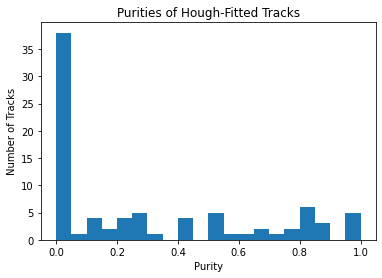

In [77]:
# Plot the purity of the all tracks of all events
purities = []
threeKMTracks = []
for event in range(len(tree2['pdg_assoc'])):
    for track in range(len(tree2['pdg_assoc'][event])):
        good = 0
        total = 0

        for particle in range(len(tree2['pdg_assoc'][event][track])):
            total += 1 # increment number of particles in the track
            if(abs(tree2['pdg_assoc'][event][track][particle]) == 321.0 or abs(tree2['pdg_assoc'][event][track][particle]) == 13.0):
                good += 1 # increment number of kaons/muons in the track
            
        purity = good/total 
        purities.append(purity)
        if good >= 3:
            threeKMTracks.append(1)
        else:
            threeKMTracks.append(0)

print("number of tracks with at least 3 kaon/muon hits: {}".format(sum(threeKMTracks)))

purities = np.array(purities)
bin_list = np.linspace(0,1,21)
print("number of tracks: " + str(len(purities)))
print("binning: " + str(bin_list))
print("purities: " + str(purities))

plt.figure()
plt.hist(purities,bins=bin_list,label="purities")
plt.xlabel('Purity')
plt.ylabel('Number of Tracks')
plt.title('Purities of Hough-Fitted Tracks')

14


Text(0.5, 1.0, 'Leftover Kaon/Muon Hits from Hough-Fitted Tracks')

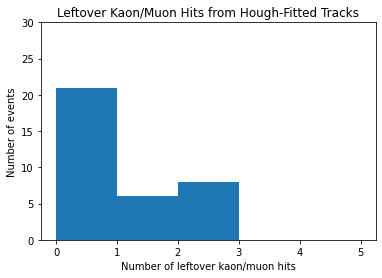

In [74]:
# Plot the amount of kaon/muon hits that were not associated with a track (per event)

# Amount of kaon/muon hits in found tracks
KM1 = []
for event in range(len(tree2['pdg_assoc'])):
    kaons1 = 0
    muons1 = 0
    for track in range(len(tree2['pdg_assoc'][event])):
        for particle in range(len(tree2['pdg_assoc'][event][track])):
            if(abs(tree2['pdg_assoc'][event][track][particle]) == 321.0):
                kaons1 += 1
            elif(abs(tree2['pdg_assoc'][event][track][particle]) == 13.0):
                muons1 +=1
    #print("Total amount of kaons associated with event {}: {}".format(event,kaons1))
    #print("Total amount of muons associated with event {}: {}".format(event,muons1))
    KM1.append(kaons1+muons1)
#print(KM1)

# Total amount of kaon/muon hits
KM2 = []
for event in range(len(tree2['pdgID'])):
    kaons2 = 0
    muons2 = 0
    for hit in range(len(tree2['pdgID'][event])):
        if (abs(tree2['pdgID'][event][hit]) == 321):
            kaons2 += 1
        if (abs(tree2['pdgID'][event][hit]) == 13):
            muons2 += 1
    #print("Total amount of kaons associated with event {}: {}".format(event,kaons2))
    #print("Total amount of muons associated with event {}: {}".format(event,muons2))
    KM2.append(kaons2+muons2)
#print(KM2)

KMdiff = np.array(KM2) - np.array(KM1)
#print("Leftover kaon/muon hits per event: {}".format(KMdiff))
count = 0
for event in range(len(KMdiff)):
    if KMdiff[event] > 0:
        count += 1
print(count)


bin_list = np.linspace(0,5,6)
#print(bin_list)
plt.figure()
plt.hist(KMdiff,bins=bin_list)
plt.xticks([0,1,2,3,4,5])
plt.yticks(np.linspace(0,30,7))
plt.xlabel('Number of leftover kaon/muon hits')
plt.ylabel('Number of events')
plt.title('Leftover Kaon/Muon Hits from Hough-Fitted Tracks')

[0. 1. 2. 3. 4. 5.]


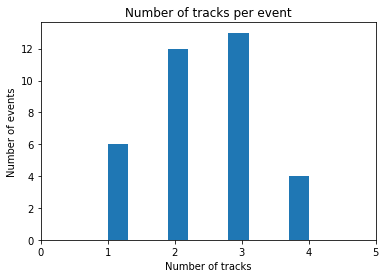

In [86]:
# Plot the amount of tracks per event
numTracks = []

for event in range(len(tree2['pdg_assoc'])):
    numTracks.append(len(tree2['pdg_assoc'][event]))

numTracks = np.array(numTracks)
#print(numTracks)
bin_list = np.linspace(0,5,6)
print(bin_list)

plt.figure()
plt.hist(numTracks)
plt.xlabel('Number of tracks')
plt.ylabel('Number of events')
plt.xticks(np.linspace(0,5,6))
plt.title('Number of tracks per event')
plt.show()


In [12]:
# Plot all of the points and trajectories (FOR DEBUGGING PURPOSES)
import plotly.graph_objects as go
import plotly.express as px
import copy

x_vals = []
y_vals = []
z_vals = []
pdg_vals = []

# set the event number
event = 4

print("event: " + str(event))
print("original # of hits: {}, cut # of hits: {}".format(len(tree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event]), len(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event])))
#print("pdgID: " + str(cutTree['Pdg_ID'][event]))

cutTree['Particle'] = copy.deepcopy(cutTree['Pdg_ID'])

# convert pdg IDs to colors
for hit in range(len(cutTree['Pdg_ID'][event])):
    if cutTree['Pdg_ID'][event][hit] == 11: # e-
        cutTree['Particle'][event][hit] = 'electron'
    elif cutTree['Pdg_ID'][event][hit] == -11: # e+
        cutTree['Particle'][event][hit] = 'positron'
    elif cutTree['Pdg_ID'][event][hit] == -13: # mu-
        cutTree['Particle'][event][hit] = 'muon'
    elif cutTree['Pdg_ID'][event][hit] == 13: # mu+
        cutTree['Particle'][event][hit] = 'muon'
    elif cutTree['Pdg_ID'][event][hit] == 321: # K+
        cutTree['Particle'][event][hit] = 'kaon'
    elif cutTree['Pdg_ID'][event][hit] == -321: # K-
        cutTree['Particle'][event][hit] = 'kaon'
    else:
        cutTree['Particle'][event][hit] = 'other'

#print("colorID: " + str(cutTree['colorID'][event]))
#print("pdgID: " + str(cutTree['Pdg_ID'][event]))


# store all of the position values
for hit in range(len(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event])):
    x_vals.append(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.xpos_'][event][hit])
    y_vals.append(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.ypos_'][event][hit])
    z_vals.append(cutTree['EcalRecHits_v3_v12/EcalRecHits_v3_v12.zpos_'][event][hit])
    pdg_vals.append(cutTree['Particle'][event][hit])
        
df = {}
df['x'] = x_vals
df['y'] = y_vals
df['z'] = z_vals
df['Particle'] = pdg_vals
#print("pdg_vals: " + str(pdg_vals))

eLayerIntercepts = []
intercept = (trajectories['etraj_sp'][event][0] + layer_dz*trajectories['enorm_sp'][event][0], 
            trajectories['etraj_sp'][event][1] + layer_dz*trajectories['enorm_sp'][event][1], 
            trajectories['etraj_sp'][event][2] + layer_dz*trajectories['enorm_sp'][event][2])
eLayerIntercepts.append(intercept)
eLayerIntercepts = np.concatenate(np.array(eLayerIntercepts))
#print(eLayerIntercepts)

traj = {}
traj['trajx'] = eLayerIntercepts[0]
traj['trajy'] = eLayerIntercepts[1]
traj['trajz'] = eLayerIntercepts[2]


# radii of containment (don't need to index the event for these because all of the eLayerIntercepts are already for the nth event)

figs = []

for hit in range(len(tree2['ax'][event])):
    hough = {}
    houghX = []
    houghY = []
    houghZ = []
    # anchor point
    anchor = (tree2['ax'][event][hit],tree2['ay'][event][hit],tree2['az'][event][hit])
    houghX.append(anchor[0])
    houghY.append(anchor[1])
    houghZ.append(anchor[2])
    # positive half
    linePos = (anchor[0] + 100*tree2['bx'][event][hit],anchor[1] + 100*tree2['by'][event][hit],anchor[2] + 100*tree2['bz'][event][hit])
    houghX.append(linePos[0])
    houghY.append(linePos[1])
    houghZ.append(linePos[2])
    # negative half
    lineNeg = (anchor[0] - 100*tree2['bx'][event][hit],anchor[1] - 100*tree2['by'][event][hit],anchor[2] - 100*tree2['bz'][event][hit])
    houghX.append(lineNeg[0])
    houghY.append(lineNeg[1])
    houghZ.append(lineNeg[2])
    hough['houghX'] = houghX
    hough['houghY'] = houghY
    hough['houghZ'] = houghZ
    figH = px.line_3d(hough, x='houghX', y ='houghY', z ='houghZ')
    figs.append(figH)
'''
for layer in range(34):
    circle = {}
    radius = radius_beam_68[layer]
    centerX = eLayerIntercepts[0][layer]
    centerY = eLayerIntercepts[1][layer]
    centerZ = eLayerIntercepts[2][layer]
    theta = np.linspace(0, 2*np.pi, 360)
    circle['circleX'] = radius * np.cos(theta) + centerX
    circle['circleY'] = radius * np.sin(theta) + centerY
    circle['circleZ'] = np.zeros(360) + centerZ
    figC = px.line_3d(circle, x='circleX', y='circleY', z='circleZ')
    figs.append(figC)
'''
fig1 = px.scatter_3d(df,x='x', y='y', z='z', color='Particle', labels={
                     "x": "X (mm)",
                     "y": "Y (mm)",
                     "z": "Z (mm)"
                    }, width=700,height=700)

fig2 = px.line_3d(traj, x="trajx", y="trajy", z="trajz", labels={
                     "trajx": "X (mm)",
                     "trajy": "Y (mm)",
                     "trajz": "Z (mm)"})

figData = ()
for fig in figs:
    figData += fig.data

fig3 = go.Figure(data=fig1.data + figData)
fig3.update_xaxes(range=[-200, 200])
fig3.update_yaxes(range=[-200, 200])
fig3.update_layout(
    scene = dict(
        xaxis = dict(nticks=6, range=[-200,200],),
                     yaxis = dict(nticks=10, range=[-200,200],),
                     zaxis = dict(nticks=10, range=[240,700],),),
    autosize=False,
    margin=dict(r=20, l=10, b=10, t=10))
fig3.update_traces(marker=dict(size=2),selector=dict(mode='markers'))


fig3.show()
#print("pdgID: " + str(cutTree['Pdg_ID'][event]))

nKaons = 0
nMuons = 0
nElectrons = 0
nPositrons = 0
nOthers = 0
for pdgID in cutTree['Pdg_ID'][event]:
    if(pdgID == 11): nElectrons +=1
    elif(pdgID == -11): nPositrons +=1
    elif(pdgID == 13 or pdgID == -13): nMuons +=1
    elif(pdgID == 321 or pdgID == -321): nKaons +=1
    else: nOthers +=1

print("SUMMARY:")
print("Number of Hits: {}".format(nKaons + nMuons + nElectrons + nPositrons + nOthers))
print("-> Kaons: {}".format(nKaons))
print("-> Muons: {}".format(nMuons))
print("-> Electrons: {}".format(nElectrons))
print("-> Positrons: {}".format(nPositrons))
print("-> Others: {}".format(nOthers))

nKaons = 0
nMuons = 0
nElectrons = 0
nPositrons = 0
nOthers = 0

# events that are super hard: 5,9


event: 4
original # of hits: 38, cut # of hits: 21


SUMMARY:
Number of Hits: 21
-> Kaons: 0
-> Muons: 3
-> Electrons: 12
-> Positrons: 2
-> Others: 4
